#### Latest version, updated: 17.07.2025 at 15:00

## **A/B Testing of new payment mechanics**

### **Brief Problem Statement:**

The test compared the impact of new payment mechanics on revenue metrics and user drop-offs.

During hypothesis testing, the target group was offered a new payment mechanics for services on the website, while the control group retained the basic mechanics. We need to analyse the results of the experiment and understand **whether it is worth launching the new payment system for all users**.

**Analysis objectives:**
- Identify key metrics;
- Determine if there are differences between the groups;
- Check the statistical significance of the differences;
- Make a decision on whether to implement the new payment system.

In [3]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import levene
from scipy.stats import normaltest
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
# importing the data
groups = pd.read_csv('groups.csv', sep=';')
groups_add = pd.read_csv('group_add.csv')
active_studs = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', sep=';')

In [5]:
groups.shape
groups.head()
groups.grp.value_counts().sort_index()

grp
A    14671
B    59813
Name: count, dtype: int64

In [6]:
groups_add.shape

(92, 2)

In [7]:
active_studs.shape

(8341, 1)

In [8]:
checks.head()
checks.shape

(541, 2)

In [9]:
# concatenate the data
all_groups = pd.concat([groups, groups_add], ignore_index=True)

# take only active users during experiment
active = pd.merge(all_groups, active_studs, left_on='id', right_on='student_id')

### **Bug Check: Check for anomalies before merging payment data**

In [10]:
# Of the 541 who paid, only 391 are active users; 149 people paid by some other method and we are not interested in them.

checks_active = checks[checks['student_id'].isin(active_studs['student_id'])]
checks_active.shape

(392, 2)

In [11]:
# leave the checks only from the active payers
active_payments = pd.merge(active, checks_active, on='student_id', how='left')
active_payments.head()

,id,grp,student_id,rev
0,1627,A,1627,990.0
1,2085,B,2085,NaN
2,2215,B,2215,NaN
3,3391,A,3391,NaN
4,3401,B,3401,NaN


### **Calculating Metrics**

We will calculate the following metrics:
- **ARPAU (average revenue per active user)** - shows how much money an active user brings in; here we take into account all participants in the experiment, even if they did not make a purchase;
- **ARPPU (average purchase amount among paying users)** - allows us to assess the ‘quality’ of paying users; perhaps the conversion rate has fallen, but the average purchase amount per customer has increased, making the customer ‘more valuable’ to us;
- **CR (conversion rate)** - there may be more users of the new mechanism, but how many users directly convert into cash for us?

In [12]:
# let's check, how many active users do we have in each group
grouped = active_payments.groupby('grp', as_index = False).agg({'student_id': 'nunique'})
grouped.head()

,grp,student_id
0,A,1538
1,B,6803


In [13]:
# payers in each groups
payers = active_payments.groupby('grp', as_index = False).rev.apply(lambda x: x.notna().sum())
payers

,grp,rev
0,A,78
1,B,314


In [14]:
# calculate total revenue by group
# revenue as a metric is not that interesting to us, since the groups vary quite significantly in terms of quantity, 
# but we need it to calculate ARPAU and ARPPU

total_revenue = active_payments.groupby('grp', as_index = False).agg({'rev' : 'sum'})
total_revenue

,grp,rev
0,A,72820.0000
1,B,394974.0035


**Calculating ARPAU**

In [15]:
# divide total revenue by the number of active users to get ARPAU:
metrics = pd.merge(grouped, total_revenue, on = 'grp')
metrics.rename(columns={'student_id': 'total_users', 'rev': 'total_revenue'}, inplace=True)
metrics['arpau'] = metrics.total_revenue / metrics.total_users
metrics

,grp,total_users,total_revenue,arpau
0,A,1538,72820.0000,47.347204
1,B,6803,394974.0035,58.058798


**Calculating ARPPU**

In [16]:
# Divide total revenue by the number of paying users to get ARPPU:

metrics = pd.merge(metrics, payers, on = 'grp')
metrics.rename(columns = {'rev': 'payers'}, inplace=True)
metrics['arppu'] = metrics.total_revenue / metrics.payers
metrics

,grp,total_users,total_revenue,arpau,payers,arppu
0,A,1538,72820.0000,47.347204,78,933.589744
1,B,6803,394974.0035,58.058798,314,1257.878992


**Calculating CR**

In [17]:
# Let's calculate the conversion rate to paying active users:
# To do this, divide the number of paying users by the total number of users.

metrics['conversion'] = metrics.payers / metrics.total_users
metrics

,grp,total_users,total_revenue,arpau,payers,arppu,conversion
0,A,1538,72820.0000,47.347204,78,933.589744,0.050715
1,B,6803,394974.0035,58.058798,314,1257.878992,0.046156


**As a result, we obtained dataframes with all calculated metrics.**

At the same time, for all metrics except conversion to payment, the **test group** performed better.

In [18]:
print(metrics)

  grp  total_users  total_revenue      arpau  payers        arppu  conversion
0   A         1538     72820.0000  47.347204      78   933.589744    0.050715
1   B         6803    394974.0035  58.058798     314  1257.878992    0.046156


### **Check of the statistical significance of differences in metrics by group**

- To check the statistical significance of the **ARPPU and ARPAU** metrics, we use **Student's t-test**, since the metrics are quantitative, the group sizes are different, the samples are not normally distributed, but they are large (> 30), and the variances in the General Population are considered equal;
- To check **CR**, we use the **z-test of proportions**, since the metric is qualitative, the samples are independent and large.

Before conducting tests, check the data for **normality** and **equality of variances**

In [19]:
# specifying the tests groups

rev_a = active_payments[active_payments['grp'] == 'A']['rev'].dropna()
rev_b = active_payments[active_payments['grp'] == 'B']['rev'].dropna()

In [20]:
# To check the normality of distributions, we use normaltest(), since our samples are quite large (> 20)
# Since p-value < 0.05 in both groups, we reject the hypothesis of normality of distributions; the distributions are not normal
# However, since the samples are large (>30), we can use the t-test

print(normaltest(rev_a))
print(normaltest(rev_b))

NormaltestResult(statistic=np.float64(30.378419638487475), pvalue=np.float64(2.5316868804220266e-07))
NormaltestResult(statistic=np.float64(6.795662714490353), pvalue=np.float64(0.033445723194625424))


In [21]:
# Let's check the equality of variances (Levene's test):
# Since p > 0.05, we cannot reject the null hypothesis of equality of variances; the variances are considered equal
# To check the statistical significance of the differences, we can use Student's t-test

levene_result = levene(rev_a, rev_b)
print(levene_result)

LeveneResult(statistic=np.float64(3.075681699981606), pvalue=np.float64(0.08025675761347022))


Let's perform a **T-test** for the average check (for the ARPPU metric):

- **Justification for choosing the statistical criterion:** We are comparing the average values of a quantitative metric between two independent groups (control group A and test group B). We have two independent, unequal samples. The variances are equal, the distribution is not normal, but the samples are large, so we use Student's t-test.


- **H0**: The average revenue per paying user in the General Population is the same in groups A and B.
- **H1**: The average revenue per paying user in the General Population differs between groups A and B.

In [22]:
# The average check in group B is higher and the difference is statistically significant (p value < 0.05)
# Hypothesis H0 is rejected

ttest_ind(rev_a, rev_b, equal_var=True)

TtestResult(statistic=np.float64(-3.1337795050930985), pvalue=np.float64(0.001856202526576587), df=np.float64(390.0))

Let's perform a **T-test** for the ARPAU metric

- **Justification for choosing the statistical criterion**: We compare the average values of a quantitative metric between two independent groups (control group A and test group B). We have two independent samples that are unequal and large. The variances are equal, so we use Student's t-test.


- **H0**: The average income per active user in General Population is the same in groups A and B.
- **H1**: The average income per active user in General Population differs between groups A and B.

In [23]:
# Let's make a copy of the df here, since we are now interested in the zero revenue values as well.

active_payments_filled = active_payments.copy()
active_payments_filled['rev'] = active_payments_filled['rev'].fillna(0)

# разделимдатафрейм на две группы
arpau_a = active_payments_filled[active_payments_filled['grp'] == 'A']['rev']
arpau_b = active_payments_filled[active_payments_filled['grp'] == 'B']['rev']

Let's check the equality of variances and check the distributions for normality:

In [24]:
# Checking the equality of variances
# p > 0.05, i.e. there are no grounds to reject the hypothesis of equality of variances, the hypotheses are considered equal
# we have differences in variances, so I use Student's t-test

levene_arpau = levene(arpau_a, arpau_b)
print(levene_arpau)

LeveneResult(statistic=np.float64(1.501460829433639), pvalue=np.float64(0.22048133327049665))


In [25]:
# Normality check
# Both p-values are significantly lower than 0.05, so we reject the hypothesis of normal distribution
# The distributions are not normal, but the samples are large, which allows us to use the t-test

normaltest_a = normaltest(arpau_a)
normaltest_b = normaltest(arpau_b)
print(normaltest_a, normaltest_b)

NormaltestResult(statistic=np.float64(2240.595797407402), pvalue=np.float64(0.0)) NormaltestResult(statistic=np.float64(7797.399211581946), pvalue=np.float64(0.0))


In [26]:
# T-test according to ARPAU, the difference is not statistically significant (p value > 0.05)
# hypothesis H0 is not rejected

ttest_ind(arpau_a, arpau_b, equal_var=True)

TtestResult(statistic=np.float64(-1.2253411073793445), pvalue=np.float64(0.22048133326988378), df=np.float64(8339.0))

Let's use the **z-test of proportions** to check whether there are statistical differences in conversion to paying users between the two groups (CR).

- **Justification for choosing the statistical criterion:** The z-test of proportions assesses whether the difference in sample conversions is statistically significant or could have occurred by chance. We have a discrete metric (whether an active user converted to a paying user or not).
- In order for us to use the z-test of proportions, the observations must be independent (which is true) and the samples must be large (which is also true), allowing us to use the test.


- **H0**: The conversion to purchase among active users in the general population is the same in groups A and B.
- **H1**: The conversion to purchase among active users in the general population differs between groups A and B.

In [27]:
total_users = active_payments.groupby('grp')['student_id'].nunique().sort_index()
payers = active_payments.groupby('grp')['rev'].apply(lambda x: x.notna().sum()).sort_index()

In [28]:
# differences in conversion between the two groups are not statistically significant (p value > 0.05)
# hypothesis H0 is not rejected

proportions_ztest(count=payers, nobs=total_users)

(np.float64(0.7629884495263746), np.float64(0.445470284371589))

### **Conclusions**

- **ARPPU**: higher in test group B (1257.88 vs. 933.59 in group A) and the difference is **statistically significant** (p ≈ 0.002);
- **ARPAU**: higher in group B (58.06 vs. 47.35 in group A), but the difference is **not statistically significant** (p ≈ 0.22);
- **CR**: higher in control group A (0.051 vs. 0.046 in group B), but the difference is **not statistically significant** (p ≈ 0.445);
- **Conclusion**: The new mechanism did not increase the share of paying active users or revenue per user, but it did result in a **significant increase in the average check size of paying users**.

**Recommendations**:
- If the client's goal is to increase revenue per user, then the new mechanism should be implemented for all users.
- However, it is worth conducting an additional experiment with a focus on conversion if the goal is to attract more new paying customers.

## **Implementing the function adding the groups_add.csv file to the already calculated metrics**

### **Task description:**

- Implement a function that will automatically load information from the additional file groups_add.csv (headers may vary) and recalculate metrics based on additional parameters.
- Implement a function that will build graphs based on the metrics received.

### **Solution**

Problem statement: Let's assume that we initially had three files with data: “groups.csv”, “active_studs.csv”, and “checks.csv”. We have already performed calculations on them, but we have been sent another file, “groups_add.csv”, with additional participants in the experiment. We don't want to recalculate the metrics, so we create a function that reads the file and calculates the metrics based on the updated data.

In [29]:
# The data has already been imported in task 1. We have three data frames: groups, active_studs, and checks.
# Let's calculate the metrics based on this data (without group_add)

# First, let's get a data frame with only active users and calculate the number of active users in each group
active_users = groups.merge(active_studs, left_on='id', right_on='student_id')
n_active = active_users.groupby('grp')['student_id'].nunique()

# Then we will obtain a data frame with payments from active users and calculate the number of active paying users by group.
payments = checks.merge(active_users, on='student_id')
n_paying_active = payments.groupby('grp')['student_id'].nunique()

# Calculate the amount of revenue by group
revenue_active = payments.groupby('grp')['rev'].sum()

# Calculate metrics
arpau = revenue_active / n_active
arppu = revenue_active / n_paying_active
cr = n_paying_active / n_active

# Combine the results into a single data frame
metrics_df = pd.DataFrame({
    'ARPAU': arpau,
    'ARPPU': arppu,
    'CR': cr
}).reset_index()

metrics_df

,grp,ARPAU,ARPPU,CR
0,A,47.439739,933.589744,0.050814
1,B,57.864567,1255.827487,0.046077


In [30]:
# We now have a data frame with a set of metrics that we collected using the same logic as in task 1.
# Now we have been sent the file “group_add.csv”. Let's write a function so that the metrics are calculated automatically.
# We also want to build graphs for each metric.

def calculate_metrics(additional_path):
    
    # Upload data
    additional_df = pd.read_csv(additional_path)
    
    # Add the data from a new df
    combined_groups = pd.concat([groups, additional_df], ignore_index=True)

    # Leave only active users
    active_combined = combined_groups.merge(active_studs, left_on='id', right_on='student_id')

    # Merge with checks
    payments_combined = checks.merge(active_combined, on='student_id')

    # Calculate active and paying users
    n_active = active_combined.groupby('grp')['student_id'].nunique()
    n_paying = payments_combined.groupby('grp')['student_id'].nunique()
    revenue = payments_combined.groupby('grp')['rev'].sum()

    # Calculate the metrics
    df_results = pd.DataFrame({
        'ARPAU': revenue / n_active,
        'ARPPU': revenue / n_paying,
        'CR': n_paying / n_active
    }).reset_index()

    # Graphics
    for metric in ['ARPAU', 'ARPPU', 'CR']:
        plt.figure()
        plt.bar(df_results['grp'], df_results[metric])
        plt.title(f'{metric} by group')
        plt.ylabel(metric)
        plt.show()

    return df_results

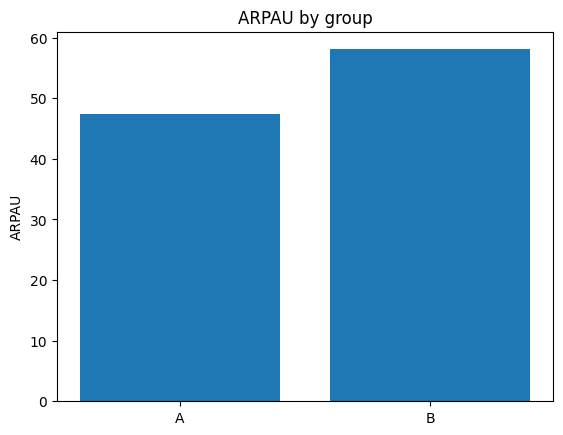

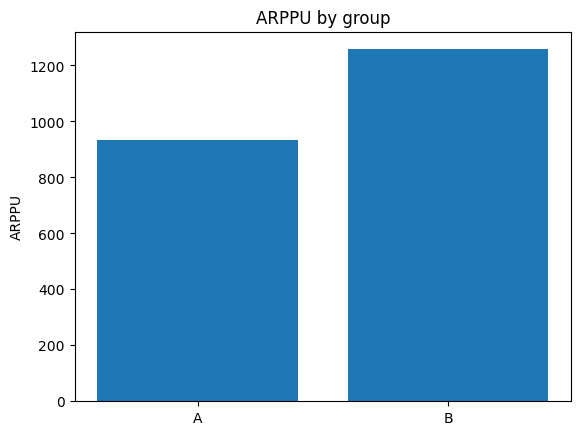

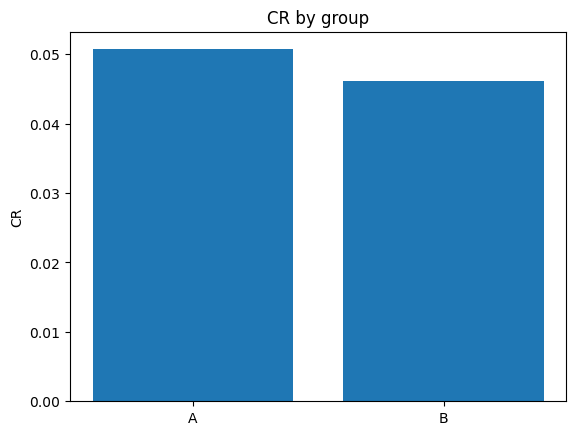

,grp,ARPAU,ARPPU,CR
0,A,47.347204,933.589744,0.050715
1,B,58.058798,1257.878992,0.046156


In [31]:
# Check that everything functions

metrics_updated = calculate_metrics('group_add.csv')
metrics_updated

**Conclusion:** Thus, we have created a function that loads additional data, calculates key metrics based on that data, and builds graphs for each metric.

## **SQL - Task (PostgreSQL)**


### **2.1 Very diligent students:**

**2.1.1 Condition**

Educational courses consist of various lessons, each of which consists of several small tasks. Each such small task is called a ‘pea’.

A user who has correctly solved 20 peas at least once during the current month is considered a very diligent student.

**2.1.2 Task**

Given the table peas, write an optimal query that will return the number of very diligent students.

NB! By diligent student, we mean a student who has correctly solved 20 tasks during the current month.

### **Solution:**

**Step 1: Check the period for which we have data:**


SELECT 
    
    MIN(timest::date) AS min_date,
    MAX(timest::date) AS max_date
    
FROM peas;

Conclusion: We have data for two days: 30 and 31 October 2021, i.e. within one month.

**Step 2: Select very diligent students**

-- First, I select students who correctly solved >= 20 problems, then count their number
-- Since students could solve the required number of problems on both days, I count DISTINCT by st_id

SELECT COUNT(DISTINCT st_id) AS hard_working_students
  
  FROM (
  
      SELECT st_id, timest:: date AS day, COUNT(*) AS correct_peas
        FROM peas
       WHERE correct = TRUE
       GROUP BY st_id, timest:: date
      HAVING COUNT(*) >= 20
       ORDER BY st_id
) AS smart_students;

**Conclusion:** In total, we have 63 students who completed >= 20 tasks this month.

### **2.2 Funnel optimisation:**

**2.2.1 Condition**

An educational platform offers students trial courses: students can solve only 30 problems per day for free. For an unlimited number of assignments in a particular subject, students must purchase full access. The team conducted an experiment to test a new payment screen.

**2.2.2 Task**

Given the tables: peas (see above), studs, and final_project_check. The following information about user groups must be retrieved in a single query:

- ARPU
- ARPAU
- CR in purchase
- CR of active users in purchase
- CR of users from math activity (subject = “math”) in purchase of math course
- ARPU is calculated relative to all users in the groups.

A user is considered active if they have solved more than 10 problems correctly in any subject during the entire period.

A user is considered active in mathematics if they have solved 2 or more problems correctly in mathematics during the entire period.

### **Solution:**

**Step 1: Create a CTE:**

- with users who have solved more than 10 tasks correctly (in any subject)
- with users who have solved ≥2 math tasks
- with all unique users who have made a purchase
- with revenue for each user

**Step 2: JOIN:**

- combine all the tables we got by ID
- sum up the metrics for the test and control groups

**Step 3: Calculate metrics:**

- ARPU: revenue per user
- ARPAU: revenue per active user
- CR_all: conversion of all users to a purchase
- CR_active: conversion of active users to a purchase
- CR_math: conversion of active math users to a math course purchase

WITH active_users AS (
    
    SELECT st_id
      FROM peas
     WHERE correct = true
     GROUP BY st_id
    HAVING COUNT(*) > 10
),

math_active_users AS (
    
    SELECT st_id
      FROM peas
     WHERE correct = true AND subject = 'Math'
     GROUP BY st_id
    HAVING COUNT(*) >= 2
),

purchases AS (
    
    SELECT DISTINCT st_id
      FROM final_project_check
),

revenue AS (
    
    SELECT st_id, SUM(money) AS total_money
      FROM final_project_check
     GROUP BY st_id
),

joined_data AS (
    
    SELECT s.test_grp,
           COUNT(DISTINCT s.st_id) AS total_users,
           SUM(r.total_money) AS total_rev,
           SUM(CASE WHEN a.st_id IS NOT NULL THEN 1 ELSE 0 END) AS active_users,
           SUM(CASE WHEN ma.st_id IS NOT NULL THEN 1 ELSE 0 END) AS math_active,
           SUM(CASE WHEN p.st_id IS NOT NULL THEN 1 ELSE 0 END) AS payers,
           SUM(CASE WHEN f.subject = 'Math' THEN 1 ELSE 0 END) AS math_payers
      FROM studs s
      LEFT JOIN revenue r ON s.st_id = r.st_id
      LEFT JOIN active_users a ON s.st_id = a.st_id
      LEFT JOIN math_active_users ma ON s.st_id = ma.st_id
      LEFT JOIN purchases p ON s.st_id = p.st_id
      LEFT JOIN final_project_check f ON s.st_id = f.st_id
     GROUP BY s.test_grp
)

SELECT 
    
    test_grp,
    total_users, active_users, math_active, payers, math_payers,
    total_rev::int,
    total_rev::float / total_users AS arpu,
    total_rev::float / active_users AS arpau,
    payers::float / total_users AS cr_all,
    payers::float / active_users AS cr_active,
    math_payers::float / math_active AS cr_math
  
  FROM joined_data;

**Conclusion:** The metric values in the test group are slightly better than in the control group, but the statistical significance of these differences needs to be verified.

# **General conclusions about the project:**

**Task 1**

Objective: Evaluate the results of an A/B test of a new payment mechanism.

What has been done: Key metrics (ARPAU, ARPPU, CR) were calculated, and a statistical analysis of the differences between the test and control groups was performed.

Result: The new payment mechanism showed better results in terms of average revenue per paying customer (ARPPU), but lower conversion to paying customers (CR) and lower average revenue per user (ARPAU). The new mechanism is recommended for implementation with a focus on revenue growth. The need for new tests was identified if the customer's goal is to convert customers into paying customers.

**Task 2**

Objective: Automate the calculation of key metrics from data from different sources by applying a function. Write a function to plot graphs for selected metrics.

What has been done: A function has been implemented that automatically loads information from an additional file and calculates key metrics based on the updated data; a function has been implemented to build graphs based on the updated data.

Result: Metrics are collected in a single data frame, additional data ‘groups_add.csv’ is loaded using the function.

**Task 3**

Objective: To count the number of very diligent students on an educational platform and calculate key metrics (ARPU, ARPAU, CR per purchase, CR of active users per purchase, CR of users from math activity per purchase of a math course) based on the results of an experiment in which a new payment screen was tested.

What has been done: 2 SQL queries were executed.

- During the first task, the number of very diligent students who correctly solved >= 20 tasks for the current month was determined. 
- During the second task, key metrics were calculated for each group in a single SQL query: ARPU, ARPAU, CR per purchase, CR of active users per purchase, CR for mathematics. Activity was determined by the number of correctly solved problems: more than 10 — active user; ≥2 in mathematics — active in mathematics.

Result:
- The result of the first query was the number of very diligent students (63) who correctly solved >= 20 tasks on the platform.
- The second query returned a table with metrics for each group, allowing us to compare the impact of the old and new payment screens on user behaviour and revenue. The test group demonstrates better performance across all metrics. It is also recommended to check the statistical significance of these differences.